In [1]:
library(SingleCellExperiment)
library(dplyr)
library(ggplot2)
library(nichenetr)
library(multinichenetr)
library(Seurat)

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

In [2]:
organism = "human"

In [3]:
options(timeout = 120)

if(organism == "human"){
  
  lr_network_all = 
    readRDS(url(
      "https://zenodo.org/record/10229222/files/lr_network_human_allInfo_30112033.rds"
      )) %>% 
    mutate(
      ligand = convert_alias_to_symbols(ligand, organism = organism), 
      receptor = convert_alias_to_symbols(receptor, organism = organism))
  
  lr_network_all = lr_network_all  %>% 
    mutate(ligand = make.names(ligand), receptor = make.names(receptor)) 
  
  lr_network = lr_network_all %>% 
    distinct(ligand, receptor)
  
  ligand_target_matrix = readRDS(url(
    "https://zenodo.org/record/7074291/files/ligand_target_matrix_nsga2r_final.rds"
    ))
  
  colnames(ligand_target_matrix) = colnames(ligand_target_matrix) %>% 
    convert_alias_to_symbols(organism = organism) %>% make.names()
  rownames(ligand_target_matrix) = rownames(ligand_target_matrix) %>% 
    convert_alias_to_symbols(organism = organism) %>% make.names()
  
  lr_network = lr_network %>% filter(ligand %in% colnames(ligand_target_matrix))
  ligand_target_matrix = ligand_target_matrix[, lr_network$ligand %>% unique()]
  
} else if(organism == "mouse"){
  
  lr_network_all = readRDS(url(
    "https://zenodo.org/record/10229222/files/lr_network_mouse_allInfo_30112033.rds"
    )) %>% 
    mutate(
      ligand = convert_alias_to_symbols(ligand, organism = organism), 
      receptor = convert_alias_to_symbols(receptor, organism = organism))
  
  lr_network_all = lr_network_all  %>% 
    mutate(ligand = make.names(ligand), receptor = make.names(receptor)) 
  lr_network = lr_network_all %>% 
    distinct(ligand, receptor)
  
  ligand_target_matrix = readRDS(url(
    "https://zenodo.org/record/7074291/files/ligand_target_matrix_nsga2r_final_mouse.rds"
    ))
  
  colnames(ligand_target_matrix) = colnames(ligand_target_matrix) %>% 
    convert_alias_to_symbols(organism = organism) %>% make.names()
  rownames(ligand_target_matrix) = rownames(ligand_target_matrix) %>% 
    convert_alias_to_symbols(organism = organism) %>% make.names()
  
  lr_network = lr_network %>% filter(ligand %in% colnames(ligand_target_matrix))
  ligand_target_matrix = ligand_target_matrix[, lr_network$ligand %>% unique()]
  
}

[1] "following are the official gene symbols of input aliases: "
  symbol alias
1  YARS1  YARS
[1] "all input symbols were official symbols"
[1] "all input symbols were official symbols"
[1] "all input symbols were official symbols"


In [4]:
cd <- read.csv('./intestine_data/intestine_for_nicheDE/counts.csv', row.names=1)
annot <- read.csv('./intestine_data/intestine_for_nicheDE/meta.csv',row.names=1)
pos <- annot[, c('x','y')]

raw_matrix = t(cd)

In [5]:
vizgen.obj <- CreateSeuratObject(count=raw_matrix,assay="RNA")
cents <- CreateCentroids(pos)

segmentations.data <- list(
    "centroids"=cents,
    "segmentation"=NULL)

coords <- CreateFOV(
    coords =CreateCentroids(pos),
    molecule=NULL,
    assay="Vizgen")

vizgen.obj[["fov"]] <-coords 

annotations <- annot[,c("annot")]
vizgen.obj$predicted.celltype<- annotations
vizgen.obj$x <- annot[,c("x")] 
vizgen.obj$y <- annot[,c("y")] 
vizgen.obj$sample <- annot[,c("sample")] 

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Warning message:
“Adding image data that isn't associated with any assays”


In [6]:
vizgen.obj

An object of class Seurat 
241 features across 7367 samples within 1 assay 
Active assay: RNA (241 features, 0 variable features)
 1 layer present: counts
 1 spatial field of view present: fov

In [7]:
dim(vizgen.obj)

[1]  241 7367

In [8]:
# working 
#vizgen.obj <- NormalizeData(vizgen.obj, normalization.method = "LogNormalize", scale.factor=10000)

In [9]:
sce = Seurat::as.SingleCellExperiment(vizgen.obj,assay="RNA")
colData(sce)

Warning message:
“Layer ‘data’ is empty”
Warning message:
“Layer ‘scale.data’ is empty”


DataFrame with 7367 rows and 8 columns
            orig.ident nCount_RNA nFeature_RNA predicted.celltype         x
              <factor>  <numeric>    <integer>        <character> <numeric>
cell1    SeuratProject         42           16             Stroma   2070.40
cell2    SeuratProject         69           18          Lymphatic   2071.30
cell3    SeuratProject         70           12          Lymphatic   2091.34
cell4    SeuratProject        156           21             Stroma   2150.84
cell5    SeuratProject        111           11          Lymphatic   2238.18
...                ...        ...          ...                ...       ...
cell8165 SeuratProject         12           12             Stroma   4093.67
cell8166 SeuratProject         14           11          Lymphatic   4386.79
cell8167 SeuratProject         12           10          Lymphatic   3804.25
cell8176 SeuratProject         12            9                BZE   3237.67
cell8198 SeuratProject         21           12   

In [10]:
#metadata_df <-vizgen.obj@meta.data
#colData(sce) <- cbind(colData(sce),metadata_df)
sce <- scuttle::logNormCounts(sce)

In [11]:
#coldata <- DataFrame(pos)
#colData(sce) <- coldata 

In [12]:
sce

class: SingleCellExperiment 
dim: 241 7367 
metadata(0):
assays(2): counts logcounts
rownames(241): Acsl1 Acta2 ... Vcan Vim
rowData names(0):
colnames(7367): cell1 cell2 ... cell8176 cell8198
colData names(9): orig.ident nCount_RNA ... ident sizeFactor
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

In [13]:
col_data <- colData(sce)
col_data$predicted.celltype <-make.names(col_data$predicted.celltype,unique=FALSE)
colData(sce) <- col_data

In [15]:
#col_data$predicted.celltype

In [16]:
sample_id = "predicted.celltype"
group_id = "sample"
celltype_id = "predicted.celltype"

In [17]:
covariates = NA
batches = NA

In [ ]:
#sce@colData
#disease 'idiopath.pulmonary.fibrosis                     normal 
#anotation     alveolar.ep        cd16    fribr  proliferat macro

In [18]:
contrasts_oi = c("'g1-g2','g2-g1'")
contrast_tbl = tibble(contrast = c("g1-g2","g2-g1"),group = c("g1","g2"))

In [ ]:
#SummarizedExperiment::colData(sce)

In [19]:
names(SummarizedExperiment::colData(sce))

[1] "orig.ident"         "nCount_RNA"         "nFeature_RNA"      
[4] "predicted.celltype" "x"                  "y"                 
[7] "sample"             "ident"              "sizeFactor"

In [ ]:
#my_data %>% select(Sepal.Length, Petal.Length)

In [ ]:
#col_data <-SummarizedExperiment::colData(sce) 
#col_data[['orig.ident']]

In [20]:
senders_oi = SummarizedExperiment::colData(sce)[,celltype_id] %>% unique()
receivers_oi = SummarizedExperiment::colData(sce)[,celltype_id] %>% unique()
sce = sce[, SummarizedExperiment::colData(sce)[,celltype_id] %in% 
            c(senders_oi, receivers_oi)
          ]

In [21]:
senders_oi
receivers_oi

[1] "Stroma"                  "Lymphatic"              
 [3] "Glial"                   "Rest.B"                 
 [5] "Blood.vasc."             "Paneth"                 
 [7] "Stem.TA"                 "neurons.enteroendocrine"
 [9] "T.cell"                  "Macrophage"             
[11] "Plasma"                  "BZE"                    
[13] "Goblet"                  "Tuft"                   
[15] "cDC.monocyte"            "MZE"                    
[17] "TZE"

[1] "Stroma"                  "Lymphatic"              
 [3] "Glial"                   "Rest.B"                 
 [5] "Blood.vasc."             "Paneth"                 
 [7] "Stem.TA"                 "neurons.enteroendocrine"
 [9] "T.cell"                  "Macrophage"             
[11] "Plasma"                  "BZE"                    
[13] "Goblet"                  "Tuft"                   
[15] "cDC.monocyte"            "MZE"                    
[17] "TZE"

In [22]:
conditions_keep = c("g1", "g2")
sce = sce[, SummarizedExperiment::colData(sce)[,group_id] %in% 
            conditions_keep
          ]

In [23]:
colnames(colData(sce))

[1] "orig.ident"         "nCount_RNA"         "nFeature_RNA"      
[4] "predicted.celltype" "x"                  "y"                 
[7] "sample"             "ident"              "sizeFactor"

In [ ]:
#colnames(colData(sce)) <- make.names(colnames(colData(sce)),unique=TRUE)
#colnames(colData(sce))

In [ ]:
#makes.names(sce[, SummarizedExperiment::colData(sce)[,celltype_id]

In [24]:
min_cells = 10
abundance_info = get_abundance_info(
  sce = sce, 
  sample_id = sample_id, group_id = group_id, celltype_id = celltype_id, 
  min_cells = min_cells, 
  senders_oi = senders_oi, receivers_oi = receivers_oi, 
  batches = batches
  )

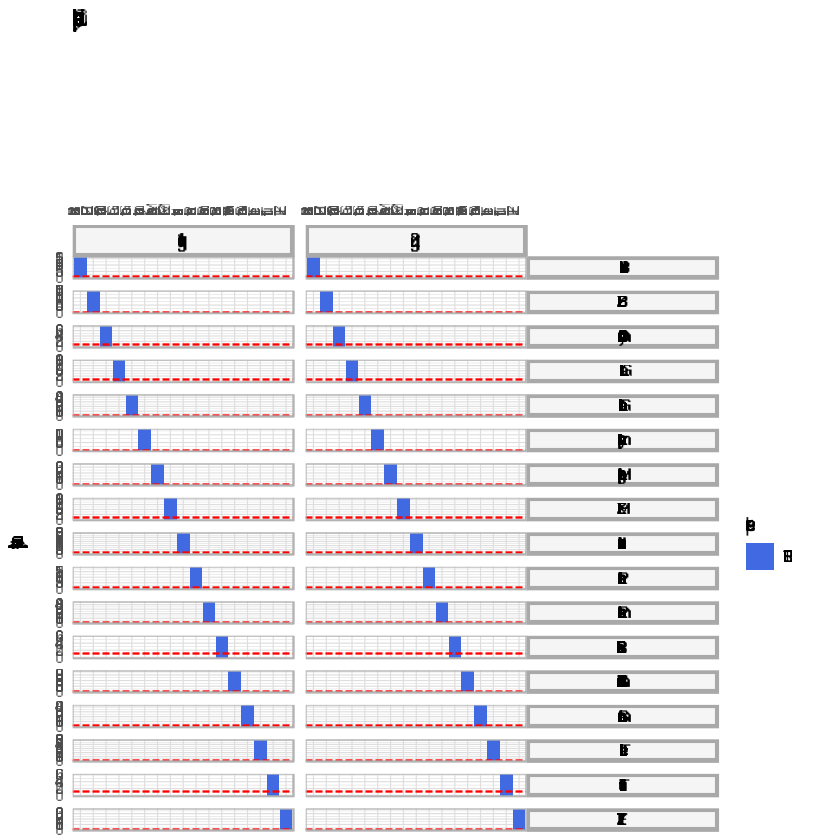

In [25]:
abundance_info$abund_plot_sample

In [26]:
# cell type filtering 
sample_group_celltype_df = abundance_info$abundance_data %>%
  filter(n > min_cells) %>%
  ungroup() %>%
  distinct(sample_id, group_id) %>%
  cross_join(
    abundance_info$abundance_data %>%
      ungroup() %>%
      distinct(celltype_id)
    ) %>%
  arrange(sample_id)

abundance_df = sample_group_celltype_df %>% left_join(
  abundance_info$abundance_data %>% ungroup()
  )

abundance_df$n[is.na(abundance_df$n)] = 0
abundance_df$keep[is.na(abundance_df$keep)] = FALSE
abundance_df_summarized = abundance_df %>%
  mutate(keep = as.logical(keep)) %>%
  group_by(group_id, celltype_id) %>%
  summarise(samples_present = sum((keep)))

celltypes_absent_one_condition = abundance_df_summarized %>%
  filter(samples_present == 0) %>% pull(celltype_id) %>% unique()
# find truly condition-specific cell types by searching for cell types
# truely absent in at least one condition

celltypes_present_one_condition = abundance_df_summarized %>%
  filter(samples_present >= 2) %>% pull(celltype_id) %>% unique()
# require presence in at least 2 samples of one group so
# it is really present in at least one condition

condition_specific_celltypes = intersect(
  celltypes_absent_one_condition,
  celltypes_present_one_condition)

total_nr_conditions = SummarizedExperiment::colData(sce)[,group_id] %>%
  unique() %>% length()

absent_celltypes = abundance_df_summarized %>%
  filter(samples_present < 2) %>%
  group_by(celltype_id) %>%
  count() %>%
  filter(n == total_nr_conditions) %>%
  pull(celltype_id)

print("condition-specific celltypes:")
## [1] "condition-specific celltypes:"
print(condition_specific_celltypes)
## [1] "L_T_TIM3._CD38._HLADR."

print("absent celltypes:")
## [1] "absent celltypes:"
print(absent_celltypes)
## character(0)

Joining with `by = join_by(sample_id, group_id, celltype_id)`
`summarise()` has grouped output by 'group_id'. You can override using the `.groups` argument.


[1] "condition-specific celltypes:"
character(0)
[1] "absent celltypes:"
 [1] "BZE"                     "Blood.vasc."            
 [3] "Glial"                   "Goblet"                 
 [5] "Lymphatic"               "MZE"                    
 [7] "Macrophage"              "Paneth"                 
 [9] "Plasma"                  "Rest.B"                 
[11] "Stem.TA"                 "Stroma"                 
[13] "T.cell"                  "TZE"                    
[15] "Tuft"                    "cDC.monocyte"           
[17] "neurons.enteroendocrine"


In [27]:
analyse_condition_specific_celltypes = FALSE

if(analyse_condition_specific_celltypes == TRUE){
  senders_oi = senders_oi %>% setdiff(absent_celltypes)
  receivers_oi = receivers_oi %>% setdiff(absent_celltypes)
} else {
  senders_oi = senders_oi %>%
    setdiff(union(absent_celltypes, condition_specific_celltypes))
  receivers_oi = receivers_oi %>%
    setdiff(union(absent_celltypes, condition_specific_celltypes))
}

sce = sce[, SummarizedExperiment::colData(sce)[,celltype_id] %in%
            c(senders_oi, receivers_oi)
          ]

In [28]:
# Genes filtering 
min_sample_prop = 0.50
fraction_cutoff = 0.05

frq_list = get_frac_exprs(
  sce = sce, 
  sample_id = sample_id, celltype_id =  celltype_id, group_id = group_id, 
  batches = batches, 
  min_cells = min_cells, 
  fraction_cutoff = fraction_cutoff, min_sample_prop = min_sample_prop)

genes_oi = frq_list$expressed_df %>% 
  filter(expressed == TRUE) %>% pull(gene) %>% unique() 
sce = sce[genes_oi, ]

ERROR: [1m[33mError[39m in `dplyr::filter()`:[22m
[1m[22m[36mℹ[39m In argument: `is.na(fraction_sample)`.
[1mCaused by error:[22m
[33m![39m object 'fraction_sample' not found


In [29]:
abundance_expression_info = process_abundance_expression_info(
  sce = sce,
  sample_id = sample_id, group_id = group_id, celltype_id = celltype_id,
  min_cells = min_cells,
  senders_oi = senders_oi, receivers_oi = receivers_oi,
  lr_network = lr_network,
  batches = batches,
 
  abundance_info = abundance_info)


ERROR: [1m[33mError[39m in `dplyr::select()`:[22m
[33m![39m Can't select columns that don't exist.
[31m✖[39m Column `gene` doesn't exist.


In [ ]:
abundance_expression_info$celltype_info$pb_df %>% head()

In [ ]:
abundance_expression_info$celltype_info$pb_df_group %>% head()

In [ ]:
abundance_expression_info$sender_receiver_info$pb_df %>% head()

In [ ]:
abundance_expression_info$sender_receiver_info$pb_df_group %>% head()

In [ ]:
  DE_info = get_DE_info(
  sce = sce,
  sample_id = sample_id, group_id = group_id, celltype_id = celltype_id,
  batches = batches, covariates = covariates,
  contrasts_oi = contrasts_oi,
  min_cells = min_cells,
  expressed_df = frq_list$expressed_df)

In [ ]:
DE_info$celltype_de$de_output_tidy %>% head()

DE_info$hist_pvals

empirical_pval = FALSE

if(empirical_pval == TRUE){
  DE_info_emp = get_empirical_pvals(DE_info$celltype_de$de_output_tidy)
  celltype_de = DE_info_emp$de_output_tidy_emp %>% select(-p_val, -p_adj) %>%
    rename(p_val = p_emp, p_adj = p_adj_emp)
} else {
  celltype_de = DE_info$celltype_de$de_output_tidy
}

In [ ]:
sender_receiver_de = combine_sender_receiver_de(
  sender_de = celltype_de,
  receiver_de = celltype_de,
  senders_oi = senders_oi,
  receivers_oi = receivers_oi,
  lr_network = lr_network
)

sender_receiver_de %>% head(20)

In [30]:
logFC_threshold = 0.50
p_val_threshold = 0.05

p_val_adj = FALSE

geneset_assessment = contrast_tbl$contrast %>%
  lapply(
    process_geneset_data,
    celltype_de, logFC_threshold, p_val_adj, p_val_threshold
  ) %>%
  bind_rows()
geneset_assessment

geneset_assessment_adjustedPval = contrast_tbl$contrast %>%
  lapply(
    process_geneset_data,
    celltype_de, logFC_threshold, p_val_adj = TRUE, p_val_threshold
    ) %>%
  bind_rows()
geneset_assessment_adjustedPval

ERROR: Error: object 'celltype_de' not found


In [ ]:
write.csv(geneset_assessment_adjustedPval,'gene_assessment_adj_pval.csv',quote=FALSE,row.names=TRUE)
write.csv(geneset_assessment,'gene_assessment.csv',quote=FALSE,row.names=TRUE)

In [ ]:
top_n_target = 250

verbose = TRUE
cores_system = 8
n.cores = min(cores_system, celltype_de$cluster_id %>% unique() %>% length())

ligand_activities_targets_DEgenes = suppressMessages(suppressWarnings(
  get_ligand_activities_targets_DEgenes(
    receiver_de = celltype_de,
    receivers_oi = intersect(receivers_oi, celltype_de$cluster_id %>% unique()),
    ligand_target_matrix = ligand_target_matrix,
    logFC_threshold = logFC_threshold,
    p_val_threshold = p_val_threshold,
    p_val_adj = p_val_adj,
    top_n_target = top_n_target,
    verbose = verbose,
    n.cores = n.cores
  )
))

ligand_activities_targets_DEgenes$ligand_activities %>% head(20)


In [ ]:
write.csv(ligand_activities_targets_DEgenes$ligand_activities,'ligand_activities.csv',quote=FALSE,row.names=TRUE)

In [ ]:
multinichenet_output = multi_nichenet_analysis(
  sce = sce, 
  celltype_id = 'celltype', sample_id = 'batch', group_id = 'batch', 
  batches = batches, covariates = covariates, 
  lr_network = lr_network, ligand_target_matrix = ligand_target_matrix, 
  contrasts_oi = contrasts_oi, contrast_tbl = contrast_tbl, 
  senders_oi = senders_oi, receivers_oi = receivers_oi,
  min_cells = min_cells, 
  fraction_cutoff = fraction_cutoff, 
  min_sample_prop = min_sample_prop,
  scenario = scenario, 
  ligand_activity_down = ligand_activity_down,
  logFC_threshold = logFC_threshold, 
  p_val_threshold = p_val_threshold, 
  p_val_adj = p_val_adj, 
  empirical_pval = empirical_pval, 
  top_n_target = top_n_target, 
  n.cores = n.cores, 
  verbose = TRUE
  )
## [1] "Make diagnostic abundance plots + define expressed genes"
## [1] "condition-specific celltypes:"
## character(0)
## [1] "absent celltypes:"
## character(0)
## [1] "Samples are considered if they have more than 10 cells of the cell type of interest"
## [1] "Genes with non-zero counts in at least 5% of cells of a cell type of interest in a particular sample will be considered as expressed in that sample."
## [1] "Genes expressed in at least 2.5 samples will considered as expressed in the cell type: L_NK_CD56._CD16."
## [1] "Genes expressed in at least 2.5 samples will considered as expressed in the cell type: L_T_TIM3._CD38._HLADR."
## [1] "Genes expressed in at least 2.5 samples will considered as expressed in the cell type: M_Monocyte_CD16"
## [1] "6010 genes are considered as expressed in the cell type: L_NK_CD56._CD16."
## [1] "7589 genes are considered as expressed in the cell type: L_T_TIM3._CD38._HLADR."
## [1] "7798 genes are considered as expressed in the cell type: M_Monocyte_CD16"
## [1] "Calculate differential expression for all cell types"
## [1] "DE analysis is done:"
## [1] "included cell types are:"
## [1] "L_T_TIM3._CD38._HLADR." "L_NK_CD56._CD16."       "M_Monocyte_CD16"       
## [1] "retained cell types"
## [1] "L_T_TIM3._CD38._HLADR." "L_NK_CD56._CD16."       "M_Monocyte_CD16"       
## [1] "Calculate normalized average and pseudobulk expression"
## [1] "Calculate NicheNet ligand activities and ligand-target links"
## [1] "Combine all the information in prioritization tables"
## [1] "Calculate correlation between LR pairs and target genes"
## [1] "There are no condition specific cell types in the data. MultiNicheNet analysis is performed in the regular way for all cell types."